# BoaviztAPI: A Bottom-Up Model to Assess the Environmental Impacts of Cloud Services

This notebook is structured according to the bottom-up methodology describes in the paper, starting from server's components.


# Utils


In [1]:
import matplotlib.pyplot as plt
import numpy as np


def plot_usage_embodied(embodied, usage):
    plt.style.use("default")

    total_embodied = sum(embodied.values())
    total_usage = sum(usage.values())
    category_names = embodied.keys()
    results = {
        "Embodied \n"
        + str(round(total_embodied, 2))
        + " kgCO2e": list(embodied.values()),
        "Usage \n" + str(round(total_usage, 2)) + " kgCO2e": list(usage.values()),
    }

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps["RdYlGn"](np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(10, 5))  # Slightly wider for better visibility
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max() * 1.1)  # Extend limit by 10% for padding

    AAAAA = [0.35, 0.65]
    ax.set_yticks(AAAAA, labels=results.keys())

    # Remove borders
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(
            AAAAA, widths, left=starts, height=0.2, label=colname, color=color
        )

        labels = []
        for value in rects.datavalues:
            if value > 1:
                labels.append(str(round(value, 2)))
            else:
                labels.append("")

        r, g, b, _ = color
        text_color = "white" if r * g * b < 0.5 else "darkgrey"
        ax.bar_label(rects, label_type="center", color=text_color, labels=labels)

    # Adjust legend location to avoid overflow issues
    ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")

    fig.subplots_adjust(right=0.85)  # Adjust subplot to prevent clipping on the right
    fig.set_figwidth(10)
    fig.set_figheight(5)

    plt.show()

# Impact factors


- Variables starting with $f$ are _impact factors_, meaning that they give an impact / quantity
- Variables starting with $i$ are directy an _impacts_.


In [2]:
f_cpu_die_gwp = 1.97
f_cpu_die_adp = 5.87e-07
f_cpu_die_pe = 2.65e01

i_cpu_base_gwp = 9.14
i_cpu_base_adp = 2.04e-02
i_cpu_base_pe = 156.43

f_nand_die_gwp = 2.20
f_nand_die_adp = 6.30e-05
f_nand_die_pe = 2.73e01

i_ram_base_gwp = 5.22
i_ram_base_adp = 1.69e-03
i_ram_base_pe = 74.00

i_ssd_base_gwp = 6.34
i_ssd_base_adp = 5.63e-04
i_ssd_base_pe = 73.98

i_hdd_gwp = 3.11e01
i_hdd_adp = 2.50e-04
i_hdd_pe = 2.76e02

f_psu_e_gwp = 2.43e01
f_psu_e_adp = 8.30e-03
f_psu_e_pe = 3.52e02

i_motherboard_gwp = 6.61e01
i_motherboard_adp = 3.69e-03
i_motherboard_pe = 8.36e02

i_assembly_gwp = 6.68
i_assembly_adp = 1.41e-06
i_assembly_pe = 6.86e01

i_casing_gwp = 1.50e02
i_casing_adp = 2.02e-02
i_casing_pe = 2.20e03

# Server characteristics


In [3]:
cpu_units = 2  # number of physical cpus
cpu_cores = 22  # cores per cpu unit
ram_capacity = 32  # in gb
ram_sticks = 12  # number of physical ram sticks

ssd_disks = [
    {"capacity": 400, "quantity": 1},
    {"capacity": 3840, "quantity": 8},
]
ssd_total = sum(disk["capacity"] * disk["quantity"] for disk in ssd_disks)
life_expectancy = 5 * 365 * 24  # In hours

# Components


## Embodied


### CPU


$$\mathcal{F}^e_{cpu} = \frac{die_{cpu} \times \mathcal{F}^{die}_{cpu} + \mathcal{I}^{base}_{cpu}}{\mathcal{D}}$$


In [4]:
die_cpu = 6.94  # in mm2

fe_cpu_gwp = (
    ((die_cpu * f_cpu_die_gwp) + i_cpu_base_gwp) / life_expectancy
) * cpu_units
fe_cpu_adp = (
    ((die_cpu * f_cpu_die_adp) + i_cpu_base_adp) / life_expectancy
) * cpu_units
fe_cpu_pe = (
    ((die_cpu * f_cpu_die_pe) + i_cpu_base_pe) / life_expectancy
) * cpu_units

print("CPU (lifecycle)")
print(f"{fe_cpu_gwp * life_expectancy} kgCO2e")
print(f"{fe_cpu_adp * life_expectancy} kgSbeq")
print(f"{fe_cpu_pe * life_expectancy} MJ")

CPU (lifecycle)
45.6236 kgCO2e
0.04080814756 kgSbeq
680.6800000000001 MJ


### NAND memory


$$
\forall NAND \in \{ssd,ram\}:
        \mathcal{F}^e_{NAND} = \frac{\frac{capacity}{density} \times \mathcal{F}^{die}_{NAND} + \mathcal{I}^{base}_{NAND}}{\mathcal{D}}
$$


In [5]:
# RAM
ram_density = 1.79  # in cm2

fe_ram_gwp = (
    ((ram_capacity / ram_density) * f_nand_die_gwp + i_ram_base_gwp) / life_expectancy
) * ram_sticks
fe_ram_adp = (
    ((ram_capacity / ram_density) * f_nand_die_adp + i_ram_base_adp) / life_expectancy
) * ram_sticks
fe_ram_pe = (
    ((ram_capacity / ram_density) * f_nand_die_pe + i_ram_base_pe) / life_expectancy
) * ram_sticks

print("RAM (lifecycle)")
print(f"{fe_ram_gwp * life_expectancy} kgCO2e")
print(f"{fe_ram_adp * life_expectancy} kgSbeq")
print(f"{fe_ram_pe * life_expectancy} MJ")

RAM (lifecycle)
534.5953072625698 kgCO2e
0.03379508379888268 kgSbeq
6744.536312849161 MJ


In [6]:
# SSDs
ssd_density = 19  # in GB/cm2

fe_ssd_gwp = 0
fe_ssd_adp = 0
fe_ssd_pe = 0

for ssd in ssd_disks:
    ssd_capacity = ssd["capacity"]  # in gb
    ssd_disks = ssd["quantity"]  # number of physical ssd disks

    fe_ssd_gwp += (
        (ssd_capacity / ssd_density) * f_nand_die_gwp + i_ssd_base_gwp
    ) * ssd_disks
    fe_ssd_adp += (
        (ssd_capacity / ssd_density) * f_nand_die_adp + i_ssd_base_adp
    ) * ssd_disks
    fe_ssd_pe += (
        (ssd_capacity / ssd_density) * f_nand_die_pe + i_ssd_base_pe
    ) * ssd_disks

fe_ssd_gwp /= life_expectancy
fe_ssd_adp /= life_expectancy
fe_ssd_pe /= life_expectancy

print("SSD (lifecycle)")
print(f"{fe_ssd_gwp * life_expectancy} kgCO2e")
print(f"{fe_ssd_adp * life_expectancy} kgSbeq")
print(f"{fe_ssd_pe * life_expectancy} MJ")

SSD (lifecycle)
3660.4284210526316 kgCO2e
0.10825436842105263 kgSbeq
45380.34631578947 MJ


### Others


$$
\mathcal{F}^e_{others} =
	\frac{\mathcal{I}^e_{motherboard} +
	\mathcal{I}^e_{psu} +
	\mathcal{I}^e_{assembly} +
	\mathcal{I}^e_{casing}}{\mathcal{D}}
$$


In [7]:
psu_weight = 2.992  # in kg
psu_units = 2

i_psu_gwp = f_psu_e_gwp * psu_weight * psu_units
i_psu_adp = f_psu_e_adp * psu_weight * psu_units
i_psu_pe = f_psu_e_pe * psu_weight * psu_units

fe_others_gwp = (
    i_motherboard_gwp + i_psu_gwp + i_assembly_gwp + i_casing_gwp
) / life_expectancy
fe_others_adp = (
    i_motherboard_adp + i_psu_adp + i_assembly_adp + i_casing_adp
) / life_expectancy
fe_others_pe = (
    i_motherboard_pe + i_psu_pe + i_assembly_pe + i_casing_pe
) / life_expectancy

print("Others")
print(f"{fe_others_gwp * life_expectancy} kgCO2e")
print(f"{fe_others_adp * life_expectancy} kgSbeq")
print(f"{fe_others_pe * life_expectancy} MJ")

Others
368.1912 kgCO2e
0.07355861 kgSbeq
5210.968 MJ


####


## Usage


### CPU


$$\mathcal{P}_{cpu}(w)=a \times \log(b \times (w + c)) + d$$


In [8]:
import math

# Using ratios for a xeon gold at https://doc.api.boavizta.org/Explanations/components/cpu/

a = 35.5688
b = 0.2438
c = 9.6694
d = -0.6087

workload = 100  # In percentage

w_cpu = (a * math.log(b * (workload + c)) + d) * cpu_units
print(f"{w_cpu} W")

232.54525830769748 W


### Ram


In [9]:
f_ram_idle = 0.19  # W/GB
f_ram_active_cons = 0.54  # W/GB

w_ram = f_ram_active_cons * (ram_capacity * ram_sticks)
print(f"{w_ram} W")

207.36 W


### SSD


In [10]:
ssd_cons = (
    5.7  # W/disk from https://www.techpowerup.com/ssd-specs/samsung-950-pro-512-gb.d74
)

w_ssd = ssd_cons * ssd_disks
print(f"{w_ssd} W")

45.6 W


### Others


$$\mathcal{P}_{other}(w) = f \times (\mathcal{P}_{cpu} + \mathcal{P}_{ram} + \mathcal{P}_{ssd})$$


In [11]:
w_others = 0.2 * (w_cpu + w_ram + w_ssd)
print(f"{w_others} W")

97.10105166153951 W


# Server


## Embodied


$$
\mathcal{F}^e_{server} =
	\mathcal{F}^e_{cpu}+
	\mathcal{F}^e_{ram}+
	\mathcal{F}^e_{storage} +
	\mathcal{F}^e_{others}
$$


In [12]:
fe_server_gwp = fe_cpu_gwp + fe_ram_gwp + fe_ssd_gwp + fe_others_gwp
fe_server_adp = fe_cpu_adp + fe_ram_adp + fe_ssd_adp + fe_others_adp
fe_server_pe = fe_cpu_pe + fe_ram_pe + fe_ssd_pe + fe_others_pe

print("Server")
print(f"{fe_server_gwp} kgCO2e")
print(f"{fe_server_adp} kgSbeq")
print(f"{fe_server_pe} MJ")

Server
0.10522462393413702 kgCO2e
5.854251364838706e-06 kgSbeq
1.3245783248547636 MJ


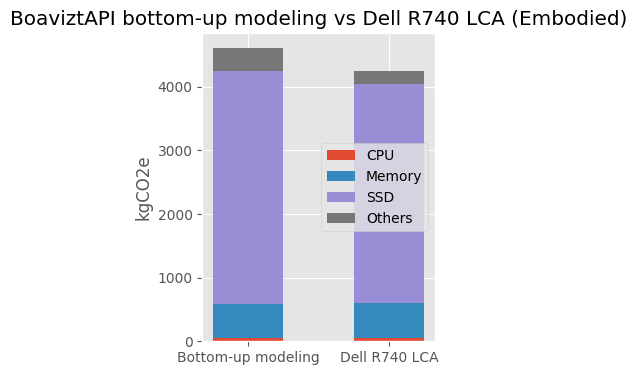

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

species = (
    "Bottom-up modeling",
    "Dell R740 LCA",
)
weight_counts = {
    "CPU": np.array([fe_cpu_gwp * life_expectancy, 46.76]),
    "Memory": np.array([fe_ram_gwp * life_expectancy, 553.33]),
    "SSD": np.array([fe_ssd_gwp * life_expectancy, 3373.5 + 64.1]),
    "Others": np.array([fe_others_gwp * life_expectancy, 207.07]),
}
width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(2)

for label, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=label, bottom=bottom)
    bottom += weight_count

ax.set_title("BoaviztAPI bottom-up modeling vs Dell R740 LCA (Embodied)")
ax.legend(loc="best")
ax.set_ylabel("kgCO2e")


fig.set_figwidth(3)
fig.set_figheight(4)

# plt.gcf().savefig("r740.pdf", bbox_inches="tight")
plt.show()

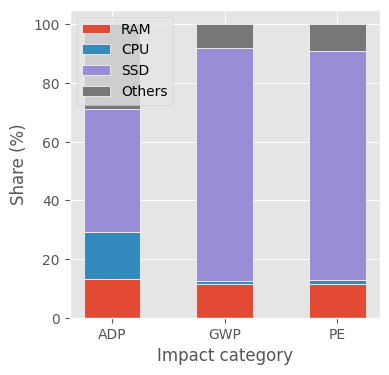

In [14]:
import pandas as pd

plt.style.use("ggplot")

fig, ax = plt.subplots()
# Data
r = [0, 1, 2]
raw_data = {
    "greenBars": [20, 1.5, 7],
    "orangeBars": [5, 15, 5],
    "blueBars": [2, 15, 18],
}
df = pd.DataFrame(raw_data)

components = ["CPU", "Memory", "SSD", "Others"]

cpu_df = [fe_cpu_adp, fe_cpu_gwp, fe_cpu_pe]
ram_df = [fe_ram_adp, fe_ram_gwp, fe_ram_pe]
ssd_df = [fe_ssd_adp, fe_ssd_gwp, fe_ssd_pe]
others_df = [fe_others_adp, fe_others_gwp, fe_others_pe]

# From raw value to percentage
totals = [i + j + k + z for i, j, k, z in zip(cpu_df, ram_df, ssd_df, others_df)]

greenBars = [i / j * 100 for i, j in zip(ram_df, totals)]
orangeBars = [i / j * 100 for i, j in zip(cpu_df, totals)]
blueBars = [i / j * 100 for i, j in zip(ssd_df, totals)]
othersBars = [i / j * 100 for i, j in zip(others_df, totals)]

# plot
barWidth = 0.5
names = ("ADP", "GWP", "PE")
# Create green Bars
plt.bar(
    r,
    greenBars,
    # color="#b5ffb9",
    edgecolor="white",
    width=barWidth,
    label="RAM",
)
# Create orange Bars
plt.bar(
    r,
    orangeBars,
    bottom=greenBars,
    # color="#f9bc86",
    edgecolor="white",
    width=barWidth,
    label="CPU",
)
# Create blue Bars
plt.bar(
    r,
    blueBars,
    bottom=[i + j for i, j in zip(greenBars, orangeBars)],
    # color="#a3acff",
    edgecolor="white",
    width=barWidth,
    label="SSD",
)

# Create blue Bars
plt.bar(
    r,
    othersBars,
    bottom=[i + j + k for i, j, k in zip(greenBars, orangeBars, blueBars)],
    # color="#a3bcff",
    edgecolor="white",
    width=barWidth,
    label="Others",
)

# Custom x axis
plt.xticks(r, names)
plt.ylabel("Share (%)")
plt.xlabel("Impact category")
# plt.xlabel("group")

# Add a legend
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.legend()

fig.set_figwidth(4)
fig.set_figheight(4)
# plt.gcf().savefig("multicriteria.pdf", bbox_inches="tight")
plt.show()

## Usage


$$\mathcal{E}_{server} = \sum_{c \in C} (\mathcal{P}_c \times \mathcal{T})$$


In [15]:
w_server = w_cpu + w_ssd + w_ram + w_others
e_server = w_server * life_expectancy
print(f"{w_server} W")
print(f"{e_server} Wh")

582.606309969237 W
25518156.376652583 Wh


# Cloud platform

For simplicity, we consider an instance with a single server with characteristics described before.


In [16]:
PUE = 1.5
elec_mix_gwp = (
    0.098 / 1000
)  # # kgCO2e/Wh, https://www.sciencedirect.com/science/article/pii/S0306261921012149?via%3Dihub
elec_mix_pe = 9.31 / 1000  # # MJ/Wh, base empreinte France 2023
elec_mix_adp = 4.86e-8 / 1000  # # kgSbeq/Wh, base empreinte France 2023
fe_dc_gwp = 2.61e-02 / 1000  # kgCO2e/Wh
fe_dc_pe = 6.61e-01 / 1000  # MJ/Wh
fe_dc_adp = 1.17e-06 / 1000  # kgSbeq/Wh

Embodied: {'CPU': 45.6236, 'RAM': 534.5953072625698, 'SSD': 3660.4284210526316, 'Others': 368.1912, 'Environment': 666.0238814306324}
Usage: {'CPU': 998.1772667599607, 'RAM': 890.0720640000002, 'SSD': 195.73344, 'Others': 416.79655415199227, 'Environment': 1250.3896624559766}


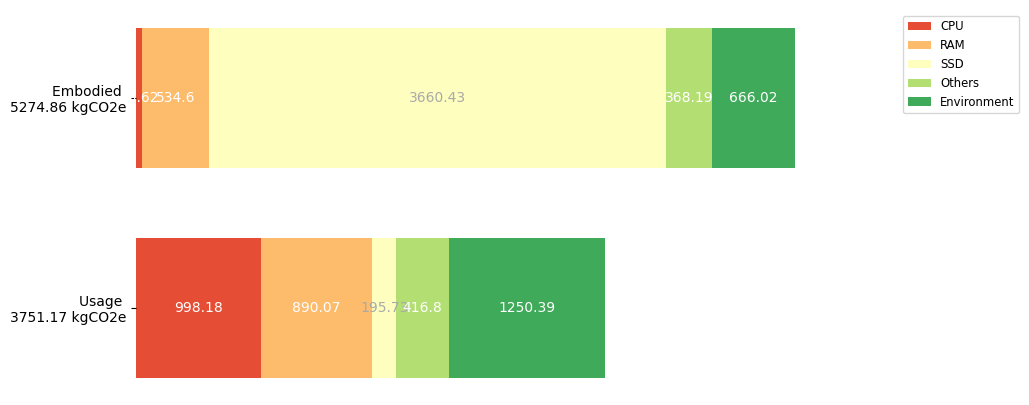

In [17]:
# Data
platform_embodied = {
    "CPU": fe_cpu_gwp * life_expectancy,
    "RAM": fe_ram_gwp * life_expectancy,
    "SSD": fe_ssd_gwp * life_expectancy,
    "Others": fe_others_gwp * life_expectancy,
    "Environment": w_server * fe_dc_gwp * life_expectancy,
}

platform_usage = {
    "CPU": (w_cpu * elec_mix_gwp) * life_expectancy,
    "RAM": (w_ram * elec_mix_gwp) * life_expectancy,
    "SSD": (w_ssd * elec_mix_gwp) * life_expectancy,
    "Others": (w_others * elec_mix_gwp) * life_expectancy,
    "Environment": w_server * ((PUE - 1) * elec_mix_gwp) * life_expectancy,
}

print("Embodied: " + str(platform_embodied))
print("Usage: " + str(platform_usage))
plot_usage_embodied(embodied=platform_embodied, usage=platform_usage)

# Cloud instance


We consider a cloud instance with 4 vCPUs, 8 GB of RAM, and 80 GB of SSD storage used for a year in France


$$ \mathcal{F}_{inst} = \mathcal{I}_{env}(\mathcal{E}_{inst}) + \sum_{\substack{r \in \{cpu, \\ ram, ssd, others\}}} \frac{\mathcal{Q}^u*{r}(instance) \times \mathcal{F}*{r}}{\mathcal{Q}^u\_{r}(platform)}$$


In [18]:
inst_vcpus = 4  # vcore
inst_vram = 8  # Gb
inst_ssd = 80  # Gb
inst_duration = 365 * 24  # in hours

## Embodied


### vCPU


In [19]:
fe_inst_cpu_gwp = fe_cpu_gwp * (inst_vcpus / (cpu_units * cpu_cores))
fe_inst_cpu_adp = fe_cpu_adp * (inst_vcpus / (cpu_units * cpu_cores))
fe_inst_cpu_pe = fe_cpu_pe * (inst_vcpus / (cpu_units * cpu_cores))

print("vCPU (embodied for instance duration)")
print(f"{fe_inst_cpu_gwp * inst_duration} kgCO2e")
print(f"{fe_inst_cpu_adp * inst_duration} kgSbeq")
print(f"{fe_inst_cpu_pe * inst_duration} MJ")

vCPU (embodied for instance duration)
0.82952 kgCO2e
0.0007419663192727272 kgSbeq
12.376000000000001 MJ


### vRAM


In [20]:
fe_inst_ram_gwp = fe_ram_gwp * (inst_vram / (ram_sticks * ram_capacity))
fe_inst_ram_adp = fe_ram_adp * (inst_vram / (ram_sticks * ram_capacity))
fe_inst_ram_pe = fe_ram_pe * (inst_vram / (ram_sticks * ram_capacity))

print("vRAM (embodied for instance duration)")
print(f"{fe_inst_ram_gwp * inst_duration} kgCO2e")
print(f"{fe_inst_ram_adp * inst_duration} kgSbeq")
print(f"{fe_inst_ram_pe * inst_duration} MJ")

vRAM (embodied for instance duration)
2.227480446927374 kgCO2e
0.00014081284916201117 kgSbeq
28.1022346368715 MJ


### SSD


In [21]:
fe_inst_ssd_gwp = fe_ssd_gwp * (inst_ssd / ssd_total)
fe_inst_ssd_adp = fe_ssd_adp * (inst_ssd / ssd_total)
fe_inst_ssd_pe = fe_ssd_pe * (inst_ssd / ssd_total)

print("vSSD (embodied for instance duration)")
print(f"{fe_inst_ssd_gwp * inst_duration} kgCO2e")
print(f"{fe_inst_ssd_adp * inst_duration} kgSbeq")
print(f"{fe_inst_ssd_pe * inst_duration} MJ")

vSSD (embodied for instance duration)
1.8819683398728182 kgCO2e
5.565777296712217e-05 kgSbeq
23.33179759166554 MJ


### Others


In [22]:
fe_inst_others_gwp = fe_others_gwp * (inst_vcpus / (cpu_units * cpu_cores))
fe_inst_others_adp = fe_others_adp * (inst_vcpus / (cpu_units * cpu_cores))
fe_inst_others_pe = fe_others_pe * (inst_vcpus / (cpu_units * cpu_cores))

print("Others (embodied for instance duration)")
print(f"{fe_inst_others_gwp * inst_duration} kgCO2e")
print(f"{fe_inst_others_adp * inst_duration} kgSbeq")
print(f"{fe_inst_others_pe * inst_duration} MJ")

Others (embodied for instance duration)
6.694385454545455 kgCO2e
0.0013374292727272726 kgSbeq
94.74487272727274 MJ


### Environment


In [23]:
i_w_cpu = w_cpu * (inst_vcpus / (cpu_units * cpu_cores))
i_w_ram = w_ram * (inst_vram / (ram_sticks * ram_capacity))
i_w_ssd = w_ssd * (inst_ssd / ssd_total)
i_w_others = w_others * (inst_vcpus / (cpu_units * cpu_cores))

i_w_total = i_w_cpu + i_w_ram + i_w_ssd + i_w_others
print(str(i_w_total) + " W")

34.405070011225334 W


$$\mathcal{I}_{env}^e(\mathcal{E}) = \mathcal{E} \times \mathcal{F}_{DC}^e$$

Here were using power (W) instead of energy (Wh) to obtain a factor per hour


In [24]:
fe_inst_env_gwp = i_w_total * fe_dc_gwp
fe_inst_env_adp = i_w_total * fe_dc_adp
fe_inst_env_pe = i_w_total * fe_dc_pe

print("Environment (embodied / h)")
print(f"{fe_inst_env_gwp} kgCO2e")
print(f"{fe_inst_env_adp} kgSbeq")
print(f"{fe_inst_env_pe} MJ")

Environment (embodied / h)
0.0008979723272929813 kgCO2e
4.0253931913133644e-08 kgSbeq
0.022741751277419946 MJ


## Usage


### vCPU


In [25]:
fu_inst_cpu_gwp = (w_cpu * elec_mix_gwp) * (inst_vcpus / (cpu_units * cpu_cores))
fu_inst_cpu_adp = (w_cpu * elec_mix_adp) * (inst_vcpus / (cpu_units * cpu_cores))
fu_inst_cpu_pe = (w_cpu * elec_mix_pe) * (inst_vcpus / (cpu_units * cpu_cores))

print("vCPU (usage for an hour)")
print(f"{fu_inst_cpu_gwp} kgCO2e")
print(f"{fu_inst_cpu_adp} kgSbeq")
print(f"{fu_inst_cpu_pe} MJ")

vCPU (usage for an hour)
0.002071766846741305 kgCO2e
1.0274272321594635e-09 kgSbeq
0.196817850440424 MJ


### vRAM


In [26]:
fu_inst_ram_gwp = (w_ram * elec_mix_gwp) * (inst_vram / (ram_sticks * ram_capacity))
fu_inst_ram_adp = (w_ram * elec_mix_adp) * (inst_vram / (ram_sticks * ram_capacity))
fu_inst_ram_pe = (w_ram * elec_mix_pe) * (inst_vram / (ram_sticks * ram_capacity))

print("vRAM (usage for an hour)")
print(f"{fu_inst_ram_gwp} kgCO2e")
print(f"{fu_inst_ram_adp} kgSbeq")
print(f"{fu_inst_ram_pe} MJ")

vRAM (usage for an hour)
0.00042336000000000007 kgCO2e
2.09952e-10 kgSbeq
0.040219200000000004 MJ


### SSD


In [27]:
fu_inst_ssd_gwp = (w_ssd * elec_mix_gwp) * (inst_ssd / ssd_total)
fu_inst_ssd_adp = (w_ssd * elec_mix_adp) * (inst_ssd / ssd_total)
fu_inst_ssd_pe = (w_ssd * elec_mix_pe) * (inst_ssd / ssd_total)

print("SSD (usage for an hour)")
print(f"{fu_inst_ssd_gwp} kgCO2e")
print(f"{fu_inst_ssd_adp} kgSbeq")
print(f"{fu_inst_ssd_pe} MJ")

SSD (usage for an hour)
1.1487917737789203e-05 kgCO2e
5.69706940874036e-12 kgSbeq
0.0010913521850899742 MJ


### Others


In [28]:
fu_inst_others_gwp = (w_others * elec_mix_gwp) * (inst_vcpus / (cpu_units * cpu_cores))
fu_inst_others_adp = (w_others * elec_mix_adp) * (inst_vcpus / (cpu_units * cpu_cores))
fu_inst_others_pe = (w_others * elec_mix_pe) * (inst_vcpus / (cpu_units * cpu_cores))

print("Others (usage for an hour)")
print(f"{fu_inst_others_gwp} kgCO2e")
print(f"{fu_inst_others_adp} kgSbeq")
print(f"{fu_inst_others_pe} MJ")

Others (usage for an hour)
0.0008650820966209885 kgCO2e
4.290101009773474e-10 kgSbeq
0.0821827991789939 MJ


### Environment


$$\mathcal{I}_{env}^u(\mathcal{E}) = \mathcal{E} \times (PUE - 1) \times \mathcal{F}_{em}$$


In [29]:
fu_inst_env_gwp = i_w_total * ((PUE - 1) * elec_mix_gwp)
fu_inst_env_adp = i_w_total * ((PUE - 1) * elec_mix_gwp)
fu_inst_env_pe = i_w_total * ((PUE - 1) * elec_mix_gwp)

print("Environment (usage for an hour)")
print(f"{fu_inst_env_gwp} kgCO2e")
print(f"{fu_inst_env_adp} kgSbeq")
print(f"{fu_inst_env_pe} MJ")

Environment (usage for an hour)
0.0016858484305500416 kgCO2e
0.0016858484305500416 kgSbeq
0.0016858484305500416 MJ


## Total


Embodied: {'CPU': 45.6236, 'RAM': 534.5953072625698, 'SSD': 3660.4284210526316, 'Others': 368.1912, 'Environment': 666.0238814306324}
Usage: {'CPU': 998.1772667599607, 'RAM': 890.0720640000002, 'SSD': 195.73344, 'Others': 416.79655415199227, 'Environment': 1250.3896624559766}


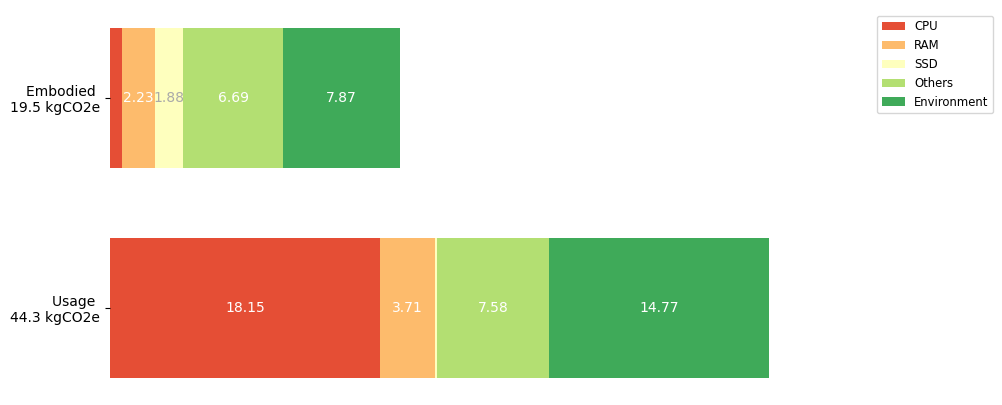

In [30]:
# Data
inst_embodied = {
    "CPU": fe_inst_cpu_gwp * inst_duration,
    "RAM": fe_inst_ram_gwp * inst_duration,
    "SSD": fe_inst_ssd_gwp * inst_duration,
    "Others": fe_inst_others_gwp * inst_duration,
    "Environment": fe_inst_env_gwp * inst_duration,
}

inst_usage = {
    "CPU": fu_inst_cpu_gwp * inst_duration,
    "RAM": fu_inst_ram_gwp * inst_duration,
    "SSD": fu_inst_ssd_gwp * inst_duration,
    "Others": fu_inst_others_gwp * inst_duration,
    "Environment": fu_inst_env_gwp * inst_duration,
}

print("Embodied: " + str(platform_embodied))
print("Usage: " + str(platform_usage))

plot_usage_embodied(embodied=inst_embodied, usage=inst_usage)